In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from scipy.stats import pearsonr
from keras.backend.tensorflow_backend import set_session
from keras import backend as K
from keras.backend import slice
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import time
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
def ANN():
    model = Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(100,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    return model

In [3]:
def GRU_1():
    model = Sequential()
    model.add(keras.layers.GRU(256, return_sequences=False))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(100,activation='relu'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    return model
model = GRU_1()
model.build(input_shape=(None, 365, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  200448    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  25700     
_________________________________________________________________
dense_1 (Dense)              multiple                  101       
Total params: 226,249
Trainable params: 226,249
Non-trainable params: 0
_________________________________________________________________


In [4]:
def LSTM_1(W,L):
    model = Sequential()
    model.add(keras.layers.LSTM(370, return_sequences=False))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.Dense(1))
    return model
model = LSTM_1(365, 0)
model.build(input_shape=(None, 365, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  553520    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  37100     
_________________________________________________________________
dense_3 (Dense)              multiple                  101       
Total params: 590,721
Trainable params: 590,721
Non-trainable params: 0
_________________________________________________________________


In [5]:
def TCNN(W,L):
    x_in = keras.layers.Input(shape=(W,3)) # Batch, Length, Dimension
    ## Block 1
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_in)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=40, dilation_rate=1, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 1
    x_res = keras.layers.Conv1D(kernel_size=1, filters=40, dilation_rate=1, padding='causal')(x_in)
    x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Activation('relu')(x_tp)
    ## Block 2
    x_block1 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=6, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 2
    x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block1)
    x_tp = keras.layers.Add()([x_tp, x_res])
    # x_tp = keras.layers.Add()([x_tp, x_block1])
    x_tp = keras.layers.Activation('relu')(x_tp)    
    ## Block 3
    
    x_block2 = x_tp
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    x_tp = keras.layers.Conv1D(kernel_size=7, filters=20, dilation_rate=12, padding='causal')(x_tp)
    # x_tp = keras.layers.BatchNormalization()(x_tp)
    x_tp = keras.layers.Activation('relu')(x_tp)
    x_tp = keras.layers.Dropout(0.6)(x_tp)
    ## add res for block 3
    # x_res = keras.layers.Conv1D(kernel_size=1, filters=20, dilation_rate=1, padding='causal')(x_block2)
    # x_tp = keras.layers.Add()([x_tp, x_res])
    x_tp = keras.layers.Add()([x_tp, x_block2])
    x_tp = keras.layers.Activation('relu')(x_tp)
    
    ## SLICE
    x_tp = keras.layers.Lambda(lambda x:slice(x,(0,80,0),(-1,-1,-1)))(x_tp) # batch, length, channels 
    x_tp = keras.layers.Flatten()(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_tp = keras.layers.Dense(100, activation='relu')(x_tp)
    x_tp = keras.layers.Dropout(0.5)(x_tp)
    x_out = keras.layers.Dense(1)(x_tp)
    model = Model(inputs=x_in, outputs=x_out)
    return model
model = TCNN(365, 0)
model.build(input_shape=(None, 365, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 365, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 365, 40)      880         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 365, 40)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 365, 40)      0           activation[0][0]                 
______________________________________________________________________________________________

In [6]:
def LSTM_3(W,L):
    model = Sequential()
    model.add(keras.layers.LSTM(50, return_sequences=True))
    model.add(keras.layers.LSTM(50, return_sequences=True))
    model.add(keras.layers.LSTM(50, return_sequences=False))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.Dense(1))
    return model
model = LSTM_3(365, 0)
model.build(input_shape=(None, 365, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                multiple                  10800     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  20200     
_________________________________________________________________
lstm_3 (LSTM)                multiple                  20200     
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  5100      
_________________________________________________________________
dense_7 (Dense)              multiple                  101       
Total params: 56,401
Trainable params: 56,401
Non-trainable params: 0
__________________________________________________

## LOSS

In [7]:
def load_data(station): ## Station in String
    flow = np.load('../usgsflow_'+station+'.npy')
    precip = np.load('../NLDAS_precip_'+station+'.npy')
    srad = np.load('../NLDAS_srad_'+station+'.npy')
    tmax = np.load('../NLDAS_tmax_'+station+'.npy')
    y = np.array(flow).reshape(-1, 1)
    indx = np.where(y>=0)[0]
    # print(precip.shape)
    date = np.load('../usgsdate_'+station+'.npy', allow_pickle=True)
    x = np.concatenate((precip, srad, tmax), axis=1)
    return x, y
def nse(y_pred, y_true):
    nse = 1-np.sum((y_pred-y_true)**2)/np.sum((y_true-np.mean(y_true))**2)
    return nse
def dataset_ld(x,y,W,L):
    obs = x.shape[0]
    features = x.shape[1]
    a = np.zeros([obs-W-L+1, W, features])
    b = np.zeros([obs-W-L+1, 1])
    for i in range(obs-W-L+1):
        a[i,:,:] = x[i:i+W,:]
        b[i,:] = y[i+W+L-1,0]    
    return a, b
def train_test_pre(x, y):
    xtrain = x[:10000]; xtest = x[10000:]
    ytrain = y[:10000]; ytest = y[10000:]
    xscale = StandardScaler().fit(xtrain)
    yscale = StandardScaler().fit(ytrain)
    Xtrain = xscale.transform(xtrain); Xtest = xscale.transform(xtest)
    Ytrain = yscale.transform(ytrain); Ytest = yscale.transform(ytest)
    return Xtrain, Xtest, Ytrain, Ytest, xscale, yscale
def custom_loss(y_true, y_pred):
    s1 = K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)
    return s1
lr = 0.0005; W=365; L=0;
f = open('../../StationArea.pkl','rb')
areas = pickle.load(f); f.close()
station = '11528700'
x, y = load_data(str(station))
area = areas[str(station)]
## Transform to Runoff
y = y*86400*1000/(area*1000*1000)
Xtrain, Xtest, Ytrain, Ytest, xscale, yscale = train_test_pre(x, y)
X_train, Y_train = dataset_ld(Xtrain, Ytrain, W, L)
X_test, Y_test = dataset_ld(Xtest, Ytest, W, L)

### LSTM-3

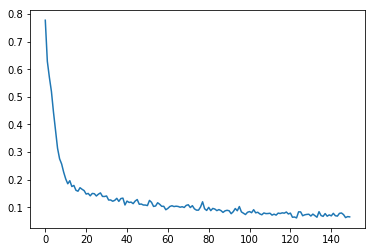

In [8]:
model = LSTM_3(365,0)
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss=custom_loss, optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=512, 
                            verbose=0, shuffle=True)
loss_LSTM3 = history.history['loss']
plt.plot(loss_LSTM3)
plt.show()

### TCNN

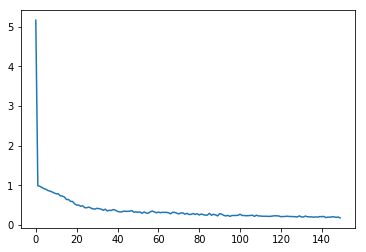

In [9]:
model = TCNN(365,0)
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss=custom_loss, optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=512, 
                            verbose=0, shuffle=True)
loss_TCNN = history.history['loss']
plt.plot(loss_TCNN)
plt.show()

### LSTM-1

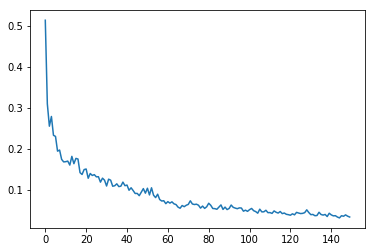

In [10]:
model = LSTM_1(365,0)
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss=custom_loss, optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=512, 
                            verbose=0, shuffle=True)
loss_LSTM1 = history.history['loss']
plt.plot(loss_LSTM1)
plt.show()

### ANN

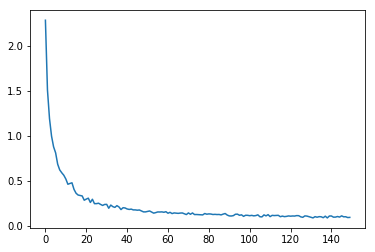

In [11]:
model = ANN()
adam = keras.optimizers.Adam(lr=lr)
model.compile(loss=custom_loss, optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=512, 
                            verbose=0, shuffle=True)
loss_ANN = history.history['loss']
plt.plot(loss_ANN)
plt.show()

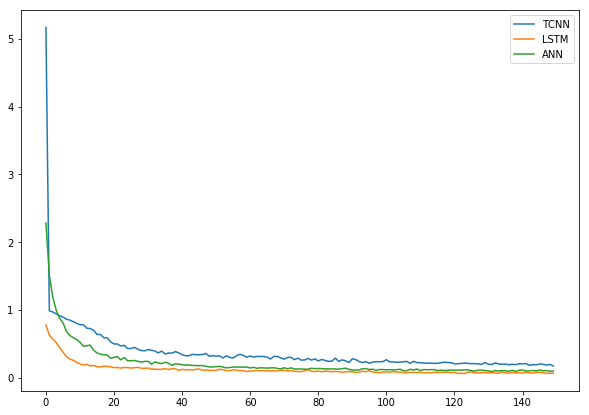

In [22]:
# plt.plot(loss_LSTM1[1:], label='LSTM-1')
fig = plt.figure(figsize=(10,7))
xpos = np.arange(0,150)
plt.plot(xpos, loss_TCNN[:], label='TCNN')
plt.plot(xpos, loss_LSTM3[:], label='LSTM')
plt.plot(xpos, loss_ANN[:], label='ANN')
plt.legend()
# plt.yscale('log')
plt.savefig('loss-a.eps', bbox_inches='tight', pad_inches=0)
plt.show()